# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [389]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [390]:
data = pd.read_csv('train.csv')

In [391]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [392]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [393]:
data.isnull().sum() #Видим, что пропуски в данных есть

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [394]:
train=train.fillna("") #Уберем пропуски на train и test, проверим на train, что их нет
test=test.fillna("")
train.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [395]:
# -- YOUR CODE HERE --
train['target'].value_counts() #Видим, что класса "0" - около 56%, класса "1" - 44% на обучающей выборке

0    3024
1    2305
Name: target, dtype: int64

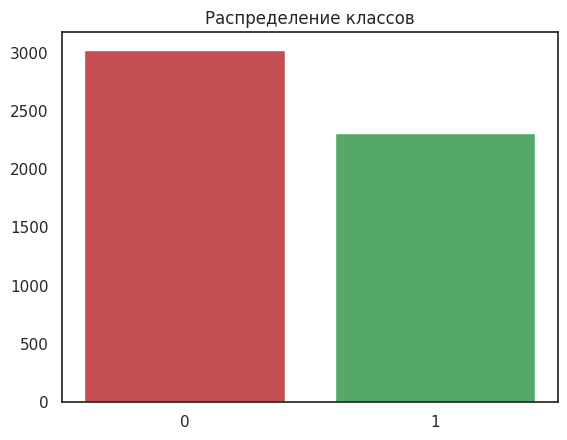

In [396]:
plt.title("Распределение классов") #Визуализируем распределение
x_axis=list((pd.DataFrame(train['target'].value_counts())).index) #Cделаем дф и возьмем значения классов, то есть "1" и "0"
y_axis=list((pd.DataFrame(train['target'].value_counts())).target) #То же самое, только берем количество
plt.bar(x_axis[0], y_axis[0], color='r')
plt.bar(x_axis[1], y_axis[1], color='g')
plt.xticks(x_axis)
plt.show()

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

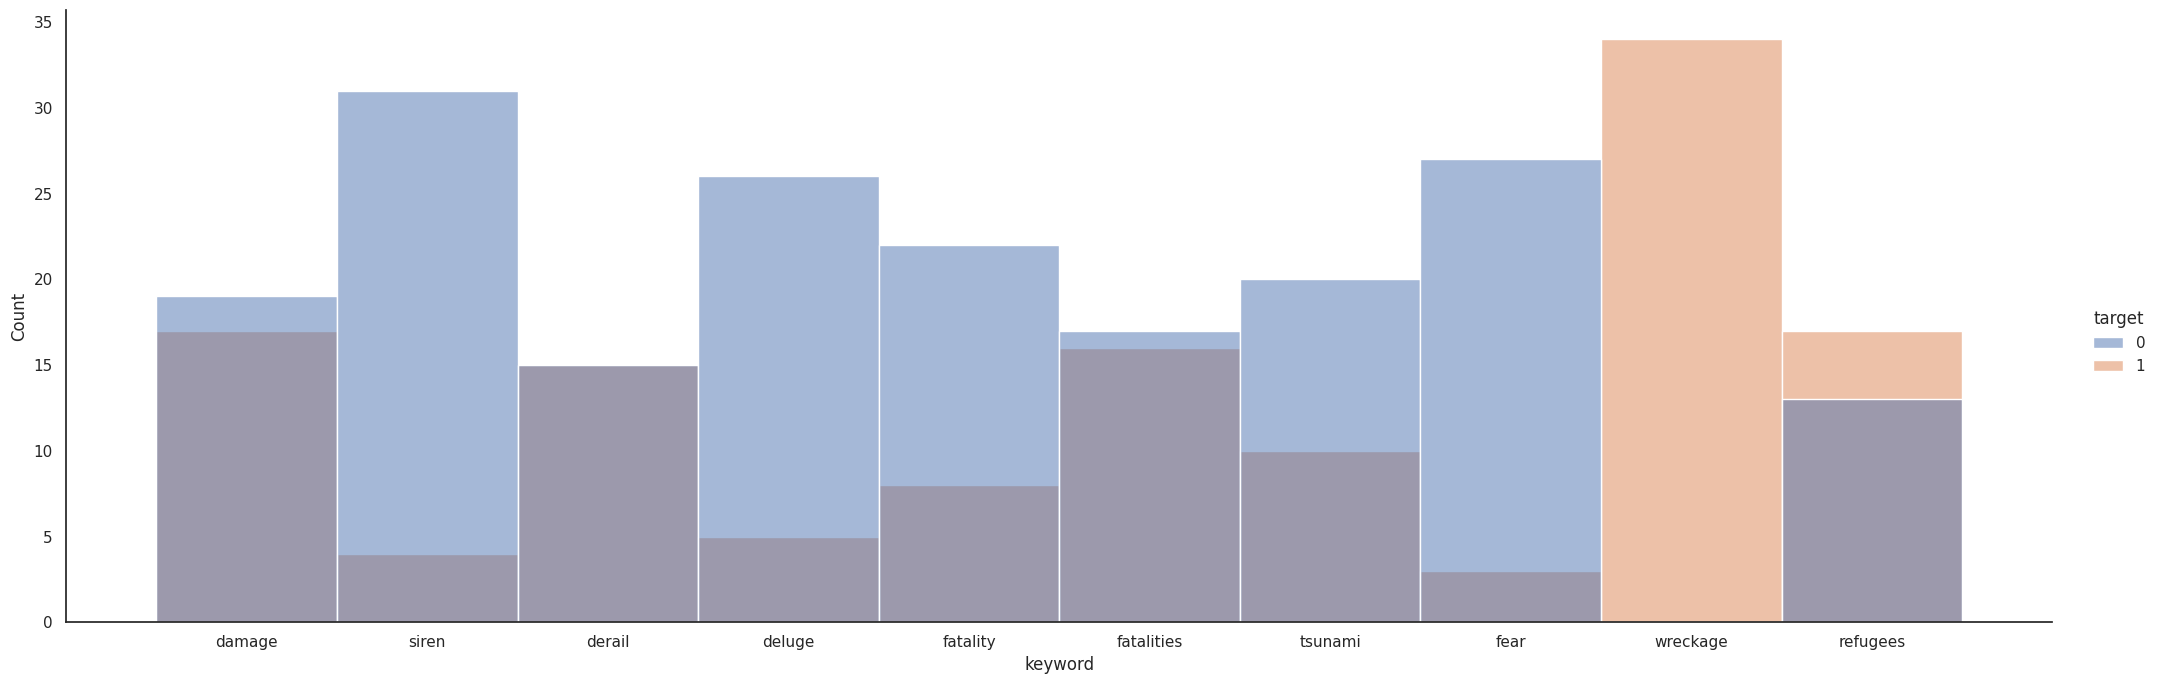

In [397]:
# -- YOUR CODE HERE --
popular_words_data=train['keyword'].value_counts().to_frame() #Сделали дф из наиболее частых значений и их количества
popular_keywords = ((list(popular_words_data.index)))[1:11] #Взяли названия этих значений со 2 по 11, тк 1 (или 0 индекс) - это пустое значение
sns.set(style='white') #Делаем "прозрачные" столбцы
sns.displot(train[train['keyword'].isin(popular_keywords)], x="keyword", hue="target", height=7, aspect=3) #строим диаграмму по данным keyword в зависимости от target
plt.show()

**Выводы**: 
- Среди наиболее часто встречающихся значений "лидирует" класс 0, в 7/10 значений количество объектов этого класса превышает количество объектов класса 1
- Все значения "wreckage" на обучающей выборке принадлежат классу 1
- Для значения "refugees" класс 1 лидирует
- Для значения "derail" количество объектов класса 1 и класса 2 совпадает
- Распределение классов для значений "damage", "fatalities" и "refugees" отличается несильно, количество почти совпадает

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [398]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [399]:
train_new=train.drop('id',axis=1) #Убрали индекс
train_new['text']=train['keyword'].astype(str)+' '+train['location'].astype(str)+' '+train['text'].astype(str) #Соединили все в столбец "text" и добавили пробелы
train_new=train_new[['text','target']] #Из полученного дф берем только новый столбец "text" и "target" 
test_new=test.drop('id',axis=1) #Это нам нужно будет для заданий далее, поэтому делаем то же самое, только для test
test_new['text']=test['keyword'].astype(str)+' '+test['location'].astype(str)+' '+test['text'].astype(str)
test_new=test[['text','target']]

In [400]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [401]:
from sklearn.feature_extraction.text import CountVectorizer
cnt_vec = CountVectorizer() 
X_train= cnt_vec.fit_transform(train_new['text']) #Обработали тренировочную выборку
X_train.shape #Размеры матрицы, строк - 5329, столбцов - 18455

(5329, 18455)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [402]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    # -- YOUR CODE HERE --
    return any(map(str.isdigit, s)) #Берем s, проверяем на isdigit с помощью map, возвращаем True, если есть хоть одна цифра (с помощью any)

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    # -- YOUR CODE HERE --
    s_helper=set(s) #Возьмем множество символов в слове
    punc=set(punctuation) # И множество символов пунктуации
    if len(s_helper & punc)>0: #Пересечем их, если пересечения есть, то возвращаем True
      return True
    else:
      return False

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    # -- YOUR CODE HERE --
    if s.startswith("#") and len(s)>1: #Проверяем, начинается ли слово с #, также не будем считать хэштегом просто #, нужно, чтобы далее были символы
      return True
    return False
    

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    # -- YOUR CODE HERE --
    if s.startswith("@") and len(s)>1: #Проверяем, начинается ли слово с @, также не будем считать упоминанием просто @, нужно, чтобы далее были символы
      return True
    return False

def investigate_vocabulary(vocabulary):
    # -- YOUR CODE HERE --
    print('With digit:      ', # -- YOUR CODE HERE --
          list((map(contains_digit,vocabulary.keys()))).count(True) #Применяем функцию с помощью map, считаем количество значений True с помощью count 
          )
    print('With punctuation:', # -- YOUR CODE HERE --
          list((map(contains_punctuation,vocabulary.keys()))).count(True)
          )
    print('Hashtags:        ', # -- YOUR CODE HERE --
          list((map(is_hashtag,vocabulary.keys()))).count(True)
          )
    print('Mentions:        ', # -- YOUR CODE HERE --
          list((map(is_mention,vocabulary.keys()))).count(True)
          )




In [403]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [404]:
vocab=cnt_vec.vocabulary_ #Достаем словарь
investigate_vocabulary(vocab) #Применяем функцию

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [405]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [406]:
# -- YOUR CODE HERE --
tw = TweetTokenizer()
vectorizer = CountVectorizer (tokenizer = tw.tokenize) #Применяем новый токенизатор
X_train2= vectorizer.fit_transform(train_new['text']) #Обучаем с новым токенизатором 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [407]:
vocab2=vectorizer.vocabulary_
investigate_vocabulary(vocab2) #вывод ответов на вопросы из предыдущего пункта

With digit:       3939
With punctuation: 7338
Hashtags:         1469
Mentions:         1678


**Сравнение:** 
- Для With digit токенизатор TweetTokenizer выдает больше слов, содержащих цифры. А именно: на 127 слов больше, чем было до этого (без токенизатора)
- Для With punctuation токенизатор TweetTokenizer выдает в 23 раза больше слов, содержащих пункутацию. До этого функция выдавала примерно 300 слов, а сейчас выдает больше 7 тысяч
- Для Hashtags и Mentions значения в предыдущем пунке были равны 0, без токенизатора они вообще не находились. Сейчас (с использованием токенизатора TweetTokenizer) функция выдает более тысячи хэштегов и упоминаний

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [408]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    # -- YOUR CODE HERE --
    if not re.search(r'[^a-zA-Z]',s): #Используем модуль re для проверки, если не находит лишних символов - выдаем True
      return True
    return False


def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    # -- YOUR CODE HERE --
    s_helper=set(s) #Создаем множество символов нашего слова
    punc_helper=set(punctuation) #создаем множество из символов пункуации 
    skobka_helper={')','(',']','[',"}",'{'} #Множество скобочек
    if len(s_helper-punc_helper)>0: #Проверяем, если в множестве s есть что-то кроме пунктуации, то оно нам не подходит (разность множеств)
      return False
    if len(s_helper&skobka_helper)>0 and len(s)>1: #Смотрим, есть ли в множестве s скобки, а также в условии сказано, что смайлик-пунктуация и минимум одна скобочка, то есть больше 2х символов, проверяем это с помощью len
      return True
    return False

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    # -- YOUR CODE HERE --
    if not s.startswith('#'): #Проверяем, начинается ли слово с #, если нет - это не хэштег
      return False
    if not re.search(r'[^a-zA-Z]',s[1:len(s)]): #Используем модуль re для проверки всех символов, кроме первого, если не находит лишних символов - выдаем True
      return True
    return False

def custom_tokenizer(s: str) -> List[str]:    
    # Кастомный токенайзер
    # -- YOUR CODE HERE --
    #0:
    s=s.lower() #Привели буквы к нижнему регистру
    #1:
    tw = TweetTokenizer()
    new_s=tw.tokenize(s) #разбили текст на токены
    #2:
    new_s2=list(filter(lambda m: contains_only_latin_letters(m)==True or is_hashtag(m)==True or is_emoji(m)==True, new_s )) #Применяем с помощью функции filter к каждому элементу нашли функции и требуем, чтобы хоть одна выдавала True
    #3:
    noise=stopwords.words("english") #Обозначим это как шумы
    new_s3=list(filter(lambda m: m not in noise, new_s2 )) #Применим функцию filter, если наше слово не в "шумах", то мы его оставляем
    #4:
    stemmer = SnowballStemmer("english")
    text_stemmed = [stemmer.stem(w) for w in new_s3] #Проводим стемминг
    return text_stemmed

In [409]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

In [410]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [411]:
X_train3=train_new['text'].head(10) #Взяли первые 10 текстов
for r in X_train3: #Применяем функцию для каждого текста и печатаем сразу (Функция выдает список, но напечатаем текстом, чтобы было красиво)
  print(*custom_tokenizer(r))

bridg ash australia collaps trent bridg among worst histori england bundl australia
hail carol stream illinoi great michigan techniqu camp thank #goblu #wrestleon
polic houston cnn tennesse movi theater shoot suspect kill polic
riot still riot coupl hour left class
wound lake highland crack path wipe morn beach run surfac wound left elbow right knee
airplan somewher expert franc begin examin airplan debri found reunion island french air accid expert #mlb
bloodi isol citi world perth came kill indian fun video smirk remorseless pakistani killer show boast
burn except idk realli burn
destroy ask destroy hous
wound maracay nirgua venezuela polic offic wound suspect dead exchang shot


## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [412]:
vectorizer_cust = CountVectorizer(tokenizer = custom_tokenizer) 
# -- YOUR CODE HERE --
y_train=train_new['target'] #Достанем ответы к тестовой и тренировочной выборкам
y_test=test_new['target']
X_train_8= vectorizer_cust.fit_transform(train_new['text']) #Применяем CountVectorizer с токенизатором 
X_test_8=vectorizer_cust.transform(test_new['text'])

2. Обучите LogisticRegression на полученных признаках.


In [413]:
from sklearn.linear_model import LogisticRegression
# -- YOUR CODE HERE --
lr = LogisticRegression()
lr.fit(X_train_8, y_train) #Обучаем
lr_pred = lr.predict(X_test_8) #Найдем вектор предсказаний модели для тестовой выборки

3. Посчитайте метрику f1-score на тестовых данных.

In [414]:
from sklearn.metrics import f1_score
# -- YOUR CODE HERE --
f8 = f1_score(y_test, lr_pred)
print(f"f1-score: {f8}") #Посчитали f1-score

f1-score: 0.7054500918554808


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [415]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1
# -- YOUR CODE HERE --
vec = TfidfVectorizer(ngram_range=(1, 1)) #tf-idf векторизатор
vec_train = vec.fit_transform(train_new['text']) #Применили векторизатор к выборкам
vec_test = vec.transform(test_new['text'])
lr9 = LogisticRegression()
lr9.fit(vec_train, y_train) #Обучили
lr_pred_9 = lr9.predict(vec_test) #Предсказали
f9 = f1_score(y_test, lr_pred_9) #Посчитали f-score
print(f"f1-score: {f9}")

f1-score: 0.7508342602892102




1. **Ответ:** Качество улучшилось, в 8 задании f1-score составлял 0.705, а при использовании tf-idf векторизатора качество повысилось до f1-score=0.75

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [416]:
# 2
# -- YOUR CODE HERE --
lr92 = LogisticRegression()
vec2 = TfidfVectorizer(max_df=0.9) #Поставили верхнюю границу
vec_train2 = vec2.fit_transform(train_new['text'])
vec_test2 = vec2.transform(test_new['text'])
lr92.fit(vec_train2, y_train)
lr_pred_92 = lr92.predict(vec_test2)
f92 = f1_score(test_new['target'], lr_pred_92)
print(f"f1-score: {f92}")

f1-score: 0.7508342602892102


In [417]:
vec_train2.shape

(5329, 18455)

In [418]:
vec_train.shape

(5329, 18455)


2. **Ответ:** Качество вообще никак не изменилось, оно осталось таким же в точности. Аналогично для размеров матриц, они равны что для TfIdfVectorizer с максимальным df 0.9, что для TfIdfVectorizer без этого ограничения. Это говорит о том, что значений df, близких к единице, нет (тк мы ничего не отбросили и не изменили матрицу)

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [419]:
# 3
# -- YOUR CODE HERE --
lr93 = LogisticRegression()
vec93 = TfidfVectorizer(min_df=0.01)
vec_train93 = vec93.fit_transform(train_new['text'])
vec_test93 = vec93.transform(test_new['text'])
lr93.fit(vec_train93, y_train)
lr_pred_93 = lr93.predict(vec_test93)
f93 = f1_score(y_test, lr_pred_93)
print(f"f1-score: {f93}")

f1-score: 0.6655555555555556



3. **Ответ:** Не удалось добиться улучшения качества. При min_df=0.1 f1-score = 0.53; при min_df=0.01 f1-score = 0.66; при min_df=0.001 f1-score = 0.74. В любом случае, удаляя слова со слишком маленьким df мы понижаем качество

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [420]:
from sklearn.feature_extraction.text import HashingVectorizer
vectorizer10 = HashingVectorizer(n_features=5000) #HashingVectorizer с количеством фичей - 5000
X_train10= vectorizer10.fit_transform(train_new['text'])
X_test10=vectorizer10.transform(test_new['text'])
lr10 = LogisticRegression()
lr10.fit(X_train10, y_train)
lr_pred10 = lr10.predict(X_test10)
f10 = f1_score(y_test, lr_pred10)
print(f'f1 score: {f10}')

f1 score: 0.7166666666666666


2. Какой из подходов показал самый высокий результат?



**Ответ:** Самый высокий результат показало использование tf-idf векторизатора без ограничений на df, в этом случае f1-score был равен 0.75
Вообще, подходы можно проранжировать так:
1.   TfIdfVectorizer: f1-score=0.75
4. TfIdfVectorizer с max_df=0.9: f1-score=0.75
5. TfIdfVectorizer с min_df=0.001: f1-score=0.74
2.   HashingVectorizer с n_features=5000: f1-score=0.71
3. CountVectorizer с кастомным токенизатором: f1-score=0.7
4. TfIdfVectorizer с min_df=0.01: f1-score=0.66
4. TfIdfVectorizer с min_df=0.1: f1-score=0.53


## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [421]:
# -- YOUR CODE HERE --
vec11 = HashingVectorizer() 
vec_train = vec11.fit_transform(train_new['text']) 
vec_test = vec11.transform(test_new['text'])
lr11 = LogisticRegression(C=10, max_iter=1000000) #Установили параметр регуляризации, равный 10 (+ выдало какую-то ошибку, пришлось увеличить max_iter )
lr11.fit(vec_train, y_train) 
lr_pred_11 = lr11.predict(vec_test) 
f11 = f1_score(y_test, lr_pred_11) 
print(f"f1-score: {f11}") #Урааа получили 0,75!! Оставим, попробуем ниже еще чего-нибудь поделать

f1-score: 0.7504187604690118


In [422]:
vec11 = TfidfVectorizer()
vec_train = vec11.fit_transform(train_new['text']) 
vec_test = vec11.transform(test_new['text'])
lr11 = LogisticRegression(C=4.8, max_iter=1000000) #вот тут другой векторизатор, получилось 0.758, чуть побольше
lr11.fit(vec_train, y_train) 
lr_pred_11 = lr11.predict(vec_test) 
f11 = f1_score(y_test, lr_pred_11) 
print(f"f1-score: {f11}")

f1-score: 0.7583603020496223
